In [65]:
import sys
sys.path.append('C:\\Program Files\\IBM\\ILOG\\CPLEX_Studio210\\cplex\\python\\20.1\\x64_win64')
sys.path.append("C:\\ProgramData\\anaconda3\\Lib\\site-packages")
import numpy as np
import pandas as pd
from docplex.mp.model import Model
import matplotlib.pyplot as plt
import random

# define the parameters
PARAMS = {
    'P': 4,        # number of caissons
    'T': 30,      # horizon
    'Cmax': 3,      # maximum number of tasks of one cluster
    'window_size': 14,   # window size
    'advanced': 5,          # advanced time
    'K': 5.993         # leakage coefficient
}   

# initialize the random values
random.seed(42)
# alpha_values = [round(random.uniform(0.03, 0.08), 3) for _ in range(PARAMS['P'])]
alpha_values = [round(random.uniform(0.01, 0.05), 3) for _ in range(PARAMS['P'])]   # degradation rate for each caisson
initial_p_values = [round(random.uniform(3.2, 3.5), 2) for i in range(PARAMS['P'])]
print("alpha values:", alpha_values)

# function to group the tasks within a window
def clustering_CR(df_window, window_size, window_start, global_task_count):
    """Grouping model"""
    # add preprocessing here
    if df_window.empty or window_size < 1:
        print(f"warning: window {window_start} has no tasks or window size is invalid")
        return df_window  # return the original dataframe if no tasks in the window

    N = df_window.shape[0]  # number of tasks in the window

    mdl = Model('Dynamic_Window_Clustering')
    
    # define the variables
    theta = mdl.binary_var_matrix(N, window_size, name='theta')
    center = mdl.binary_var_matrix(window_size, window_size, name='center')  
    cluster = mdl.binary_var_list(window_size, name='cluster')
    a = mdl.integer_var_list(N, name='a', lb=0, ub=window_size)
    b = mdl.integer_var_list(N, name='b', lb=0, ub=window_size)
    # define auxiliary variable z
    z = mdl.binary_var_matrix(window_size, window_size, name='z')

    M1 = 1
    M = 10
    # objective function
    mdl.minimize(mdl.sum(cluster[k] for k in range(window_size)))
    
    # # linearization of the auxiliary variable z
    # mdl.add_constraints(z[k, t] <= theta[n, k] for n in range(N) for k in range(window_size) for t in range(window_size))
    # mdl.add_constraints(z[k, t] <= center[k, t] for k in range(window_size) for t in range(window_size))
    # mdl.add_constraints(z[k, t] >= theta[n, k] + center[k, t] - 1 for n in range(N) for k in range(window_size) for t in range(window_size))
        
    # at least one tasks needed to activate the cluster
    mdl.add_constraints(theta[n, k] <= cluster[k] for n in range(N) for k in range(window_size))
    # every task must be assigned to one cluster
    mdl.add_constraints(mdl.sum(theta[n, k] for k in range(window_size)) == 1 for n in range(N))
    
    # maximum capacity in each cluster
    mdl.add_constraints(mdl.sum(theta[n, k] for n in range(N)) <= PARAMS['Cmax'] for k in range(window_size))
    
    # Each cluster only have one center
    mdl.add_constraints(mdl.sum(center[k, t] for t in range(window_size)) == cluster[k] for k in range(window_size))

    # we can only have one cluster each day
    mdl.add_constraints(mdl.sum(center[k, t] for k in range(window_size)) <= 1 for t in range(window_size))
    # mdl.add_constraints(theta[n, k] <= mdl.sum(center[k, t] for t in range(window_size)) for n in range(N) for k in range(window_size))

    # # 添加全局约束：确保每一天的任务总数不超过 PARAMS['Cmax']
    # for t in range(window_start, window_start + window_size):
    #     mdl.add_constraint(global_task_count[t] + mdl.sum(theta[n, k] for n in range(N) for k in range(window_size) if t == (window_start + k)) <= PARAMS['Cmax'])

    # mdl.add_constraints(theta[n, k] <= mdl.sum(center[k, t] for t in range(window_size)) for n in range(N) for k in range(window_size))

    # mdl.add_constraints(mdl.sum(theta[n, k] for n in range(N)) * center[k, t] <= PARAMS['Cmax'] for k in range(window_size) for t in range(window_size))
    # # 替换原来的非线性约束
    # mdl.add_constraints(mdl.sum(z[k, t] for n in range(N)) <= PARAMS['Cmax'] for k in range(window_size) for t in range(window_size))


    # task grouping and center determination
    # print(theta.keys())  # make sure (n, k) is in keys
    # print(center.keys())  # make sure (k, t) is in keys

    # define the possible advanced or delayed range for each task
    for n in range(N):
        local_time = df_window.iloc[n]['window_time']
    #     # print(local_time)
        mdl.add_constraint(a[n] >= local_time - PARAMS['advanced'])
        mdl.add_constraint(a[n] >= 0)
        mdl.add_constraint(b[n] <= local_time + int((3.2 - 3.0)/alpha_values[int(df_window.iloc[n]["CSEM"])]))
        mdl.add_constraint(b[n] <= window_size)
        # mdl.add_constraint(b[n] <= 5)

        for t in range(window_size):
            mdl.add_constraints(t * center[k,t] >= a[n] - M * (1 - theta[n, k]) - M * (1 - center[k, t]) for k in range(window_size))
            mdl.add_constraints(t * center[k,t] <= b[n] + M * (1 - theta[n, k]) for k in range(window_size))

    # solve the model
    solution = mdl.solve()


    if not solution:
        print(f"Failed to solve the problem: {mdl.solve_details.status}")
        return None
    
    # result processing
    # convert local time back to original time and get the center for each task
    centers = {}
    for n in range(N):
        for k in range(window_size):
            for t in range(window_size):
                if solution.get_value(center[k, t]) == 1.0:  # find the center for each cluster
                    # print(f"Task {n} (CSEM={df_window.iloc[n]['CSEM']}) assigned to cluster {t + window_start}")
                    centers[n] = t + window_start  # change the time back to the original time
                    break

    # update the center column of the original global dataframe
    for n in range(N):
        for k in range(window_size):
            if solution.get_value(theta[n, k]) == 1.0:
                df_window.at[n, 'CENTER'] = centers.get(n, 0)  

    return df_window

# function to calculate the gas leakage before clustering
def calculate_gas_leakage_before(df, T):
    total_leakage = 0

    for csem in df['CSEM'].unique():
        # filter the data for the current CSEM
        csem_data = df[df['CSEM'] == csem]
        x_operations = csem_data[csem_data['OPERATION'] == 'x']
        y_operations = csem_data[csem_data['OPERATION'] == 'y']

        # if there are more than two CR, add 1.80 for each additional CR (apart from these two) and calculate the leakage for the first and last CR independently
        if len(x_operations) >= 2:
            total_leakage += 1.80 * (len(x_operations) - 1)

        # deal with the first 'x' operation
        first_x = x_operations.iloc[0]
        if not pd.isna(first_x['INITIALP']):
            total_leakage += (first_x['INITIALP'] - 3.2) * PARAMS['K']

        # deal with the last 'x' operation
        last_x = x_operations.iloc[-1]
        if not y_operations.empty:
            # if there is a 'y' operation
            total_leakage += 1.80
        else:
            # if there is no 'y' operation
            alpha = alpha_values[last_x['CSEM']]
            total_leakage += (T - last_x['DATE'] - 1) * alpha * PARAMS['K']

    return total_leakage

# function to calculate the gas leakage after clustering
def calculate_gas_leakage_after(df, T):
    total_leakage = 0

    for csem in df['CSEM'].unique():
        # filter the data for the current CSEM
        csem_data = df[df['CSEM'] == csem]
        x_operations = csem_data[csem_data['OPERATION'] == 'x']
        y_operations = csem_data[csem_data['OPERATION'] == 'y']
        alpha = alpha_values[csem]

        # deal with the 'x' operations in the middle
        for i in range(1, len(x_operations)):
            current_x = x_operations.iloc[i]
            previous_x = x_operations.iloc[i - 1]
            center_diff = current_x['CENTER'] - previous_x['CENTER']
            total_leakage += center_diff * alpha * PARAMS['K']

        # deal with the first 'x' operation
        if not x_operations.empty:
            first_x = x_operations.iloc[0]
            total_leakage += first_x['CENTER'] * alpha * PARAMS['K']

        # deal with the last 'x' operation
        last_x = x_operations.iloc[-1]
        if not y_operations.empty:
            # if there is a 'y' operation
            y_center = y_operations['CENTER'].iloc[0]
            total_leakage += (y_center - last_x['CENTER']) * alpha * PARAMS['K']
        else:
            # if there is no 'y' operation
            total_leakage += (T - last_x['DATE'] - 1) * alpha * PARAMS['K']

    return total_leakage

def main(window_size):
    """Main function"""
    
    df = pd.read_csv('maintenance_plan.csv')
    df_init = df.copy()
    df_history_list = []
    df_history_list.append(df_init)
    sliding_windows_starts = []
    sliding_windows_ends = []
    df['CENTER'] = 0  # initialize the center column
    # 全局变量：记录每一天的任务数量
    global_task_count = [0] * PARAMS['T']
    window_start = 0

    while window_start <= PARAMS['T']:
        # dynamic window selection
        window_end = window_start + window_size
        if window_end > PARAMS['T']:
            window_end = PARAMS['T']
        
        sliding_windows_starts.append(window_start)
        sliding_windows_ends.append(window_end)
        mask = (df['DATE'] >= window_start) & (df['DATE'] < window_end) & (df['OPERATION']== 'x')
        window_df = df.loc[mask].copy()

        # task local time conversion
        window_df['window_time'] = window_df['DATE'] - window_start
        print("window", window_df)
        # get only first tasks of each caisson in the window
        first_tasks = window_df.groupby('CSEM', as_index=False).first()
        print("first tasks", first_tasks)
        # print(alpha_values)
    
        # window_df.loc[df['window_time'] != 0, 'CENTER'] = 0  # reset the center column for the current window


        # clustering these first tasks in the window
        clustered_df = clustering_CR(first_tasks, window_size, window_start, global_task_count)
        # print(clustered_df)
        
        if clustered_df is not None:
            # update the center column of original dataframe
            df.loc[mask, 'CENTER'] = df.loc[mask, 'CSEM'].map(clustered_df.set_index('CSEM')['CENTER']).fillna(df.loc[mask, 'CENTER'])
            
            # update the secondary tasks time
            update_secondary_tasks(df, clustered_df, window_start, window_end)

            # update the center column of the original dataframe
            
            # 更新全局任务计数列表
            for _, row in clustered_df.iterrows():
                task_date = row['CENTER']
                global_task_count[task_date] += 1
        # slide the window
        window_start += int(window_size/2)  # overlapping window
        df_history_list.append(df.copy())
        print (window_start)
        # window_start += window_size   # non-overlapping window
        if window_end>=PARAMS['T']:
            break

    # Updates the center column of the RE operation, which will not be grouped
    df.loc[df['OPERATION'] == "y", 'CENTER'] = df.loc[df['OPERATION'] == "y", 'DATE']

    # Processing of the remaining tasks that are not assigned to a center and cannot be updated
    mask_remain = (df['OPERATION'] == "x") & (df['CENTER'] == 0)
    df.loc[mask_remain, 'CENTER'] = df.loc[mask_remain, 'DATE']

    # result verification
    # assert df['CENTER'].notna().all(), "Some tasks are not clustered"
    return df, df_history_list, sliding_windows_starts, sliding_windows_ends

# function to update the secondary tasks date of each window
def update_secondary_tasks(main_df, clustered_df, window_start, window_end):
    """Update the secondary tasks time"""
    for caisson in clustered_df["CSEM"].unique():
        # get the tasks in the same caisson
        tasks = main_df[
            (main_df['CSEM'] == caisson) & 
            (main_df['DATE'].between(window_start, window_end))
        ]
        
        if len(tasks) > 1:
            # get the second task index
            second_idx = tasks.index[1]
            main_df.loc[second_idx, 'CENTER'] = 0
            # get the previous center time amd calculate the new time for the second task
            center_time = clustered_df.loc[clustered_df['CSEM'] == caisson, 'CENTER'].iloc[0]
            
            # calulate the new time
            alpha = alpha_values[caisson]
            # print(center_time)
            # print(alpha)
            new_date = int(center_time + 1 + (3.5-3.2)/alpha)
            # print(new_date)
            
            # update the time
            main_df.loc[second_idx, ['DATE', 'CENTER']] = new_date, new_date





alpha values: [0.036, 0.011, 0.021, 0.019]


In [66]:

result_df, df_history_list, sliding_windows_starts, sliding_windows_ends = main(PARAMS['window_size'])

# calculate the cost before grouping
operation_x_count = (result_df['OPERATION'] == 'x').sum()
operation_y_count = (result_df['OPERATION'] == 'y').sum()
before_cost = operation_x_count * 10 + operation_y_count * 100

window    INDEX  CSEM  INITIALP OPERATION  DATE  CENTER  window_time
0      0     0      3.42         x     6       0            6
4      4     2      3.47         x    12       0           12
6      6     3      3.23         x     1       0            1
first tasks    CSEM  INDEX  INITIALP OPERATION  DATE  CENTER  window_time
0     0      0      3.42         x     6       0            6
1     2      4      3.47         x    12       0           12
2     3      6      3.23         x     1       0            1


7
window    INDEX  CSEM  INITIALP OPERATION  DATE  CENTER  window_time
1      1     0      3.42         x    15       0            8
3      3     1      3.40         x    18       0           11
4      4     2      3.47         x    12      11            5
7      7     3      3.23         x    17       0           10
first tasks    CSEM  INDEX  INITIALP OPERATION  DATE  CENTER  window_time
0     0      1      3.42         x    15       0            8
1     1      3      3.40         x    18       0           11
2     2      4      3.47         x    12      11            5
3     3      7      3.23         x    17       0           10
14
window    INDEX  CSEM  INITIALP OPERATION  DATE  CENTER  window_time
1      1     0      3.42         x    15      20            1
2      2     0      3.42         x    24       0           10
3      3     1      3.40         x    18      20            4
5      5     2      3.47         x    27       0           13
7      7     3      3.23         x    1

In [67]:
len(df_history_list)

5

In [68]:
df

,INDEX,CSEM,INITIALP,OPERATION,DATE,CENTER
0,0,0,3.42,x,6,11
1,1,0,3.42,x,15,27
2,2,0,3.42,x,36,36
3,3,1,3.40,x,18,27
4,4,2,3.47,x,12,20
5,5,2,3.47,x,27,27
6,6,3,3.23,x,1,11
7,7,3,3.23,x,17,27


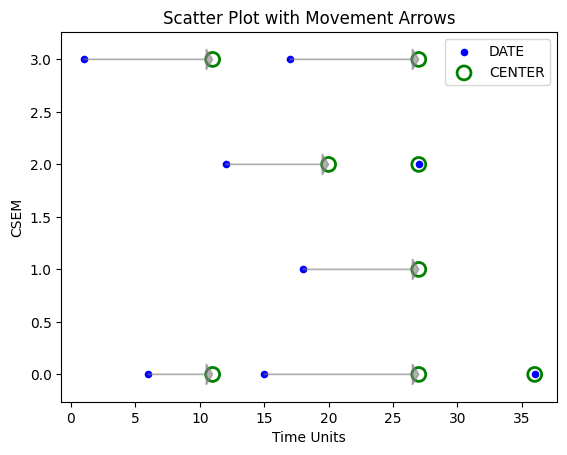

In [69]:
df = df_history_list[3]
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt

# 绘制散点图，使用不同的 marker
plt.scatter(df['DATE'], df['CSEM'], color='blue', marker='o', label='DATE', s=20)  # 小蓝色实心圆
plt.scatter(df['CENTER'], df['CSEM'], edgecolors='green', facecolors='none', marker='o', label='CENTER', s=100, linewidths=2)  # 大黄色圆环

# 添加箭头，从 (DATE, CSEM) 指向 (CENTER, CSEM)
for i in range(len(df)):
    plt.arrow(df['DATE'][i], df['CSEM'][i], 
              df['CENTER'][i] - df['DATE'][i], 0,  # x 方向的变化，y 方向保持不变
              head_width=0.2, head_length=0.5, 
              color='gray', alpha=0.6, length_includes_head=True)

plt.xlabel('Time Units')
plt.ylabel('CSEM')
plt.legend()
plt.title('Scatter Plot with Movement Arrows')

plt.show()



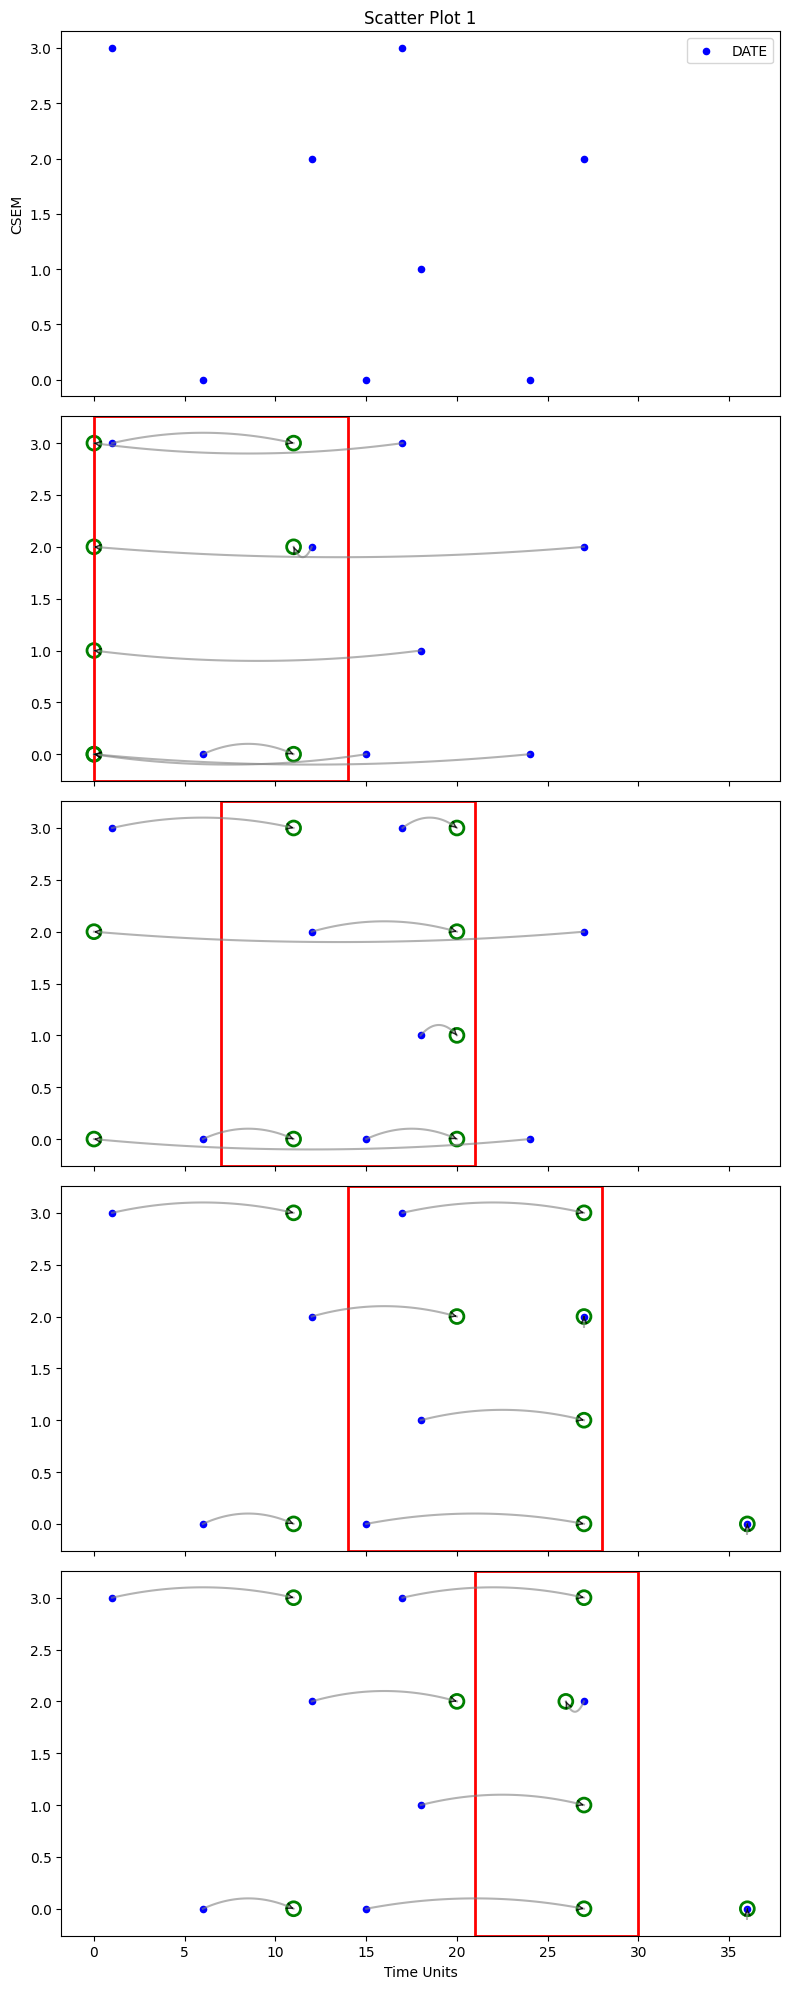

In [70]:
import matplotlib.pyplot as plt

def plot_all_dfs(df_history_list):
    n = len(df_history_list)  # 确定 df 的数量
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(8, 4 * n), sharex=True)
    
    if n == 1:
        axes = [axes]  # 确保 axes 是一个可迭代列表
    
    for i, df in enumerate(df_history_list):
        ax = axes[i]
        if i==0:
            ax.scatter(df['DATE'], df['CSEM'], color='blue', marker='o', label='DATE', s=20)
            ax.set_ylabel('CSEM')
            ax.set_title(f'Scatter Plot {i+1}')
            ax.legend()
            continue
    
        
        # 绘制散点图
        ax.scatter(df['DATE'], df['CSEM'], color='blue', marker='o', label='DATE', s=20)
        ax.scatter(df['CENTER'], df['CSEM'], edgecolors='green', facecolors='none', marker='o', label='CENTER', s=100, linewidths=2)
        
        # 添加弯曲箭头
        for j in range(len(df)):
            x_start, y_start = df['DATE'][j], df['CSEM'][j]
            x_end, y_end = df['CENTER'][j], df['CSEM'][j]
            
            # 计算箭头弯曲的控制点
            mid_x = (x_start + x_end) / 2
            mid_y = y_start + (0.2 if x_end > x_start else -0.2)  # 右弯向上，左弯向下
            
            # 生成贝塞尔曲线的点
            t = np.linspace(0, 1, 100)
            curve_x = (1 - t) ** 2 * x_start + 2 * (1 - t) * t * mid_x + t ** 2 * x_end
            curve_y = (1 - t) ** 2 * y_start + 2 * (1 - t) * t * mid_y + t ** 2 * y_end
            
            ax.plot(curve_x, curve_y, color='gray', alpha=0.6)
            ax.annotate('', xy=(curve_x[-1], curve_y[-1]), xytext=(curve_x[-2], curve_y[-2]),
                        arrowprops=dict(arrowstyle='->', color='black', alpha=0.8))
        # 添加红色框框
        start = sliding_windows_starts[i-1]
        end = sliding_windows_ends[i-1]

        ax.add_patch(plt.Rectangle((start, ax.get_ylim()[0]), end-start, ax.get_ylim()[1]-ax.get_ylim()[0],
                                      edgecolor='red', facecolor='none', linewidth=2))
    axes[-1].set_xlabel('Time Units')  # 只在最后一个子图设置 x 轴标签
    plt.tight_layout()
    plt.show()

# 调用函数绘图
plot_all_dfs(df_history_list)


In [12]:
df_history_list[1]

,INDEX,CSEM,INITIALP,OPERATION,DATE,CENTER
0,0,0,3.42,x,6,11
1,1,0,3.42,x,15,0
2,2,0,3.42,x,24,0
3,3,1,3.40,x,18,0
4,4,2,3.47,x,12,11
5,5,2,3.47,x,27,0
6,6,3,3.23,x,1,11
7,7,3,3.23,x,17,0


In [ ]:


print(f"Cost before grouping: {before_cost}")

# calculate the cost after grouping
operation_x_center_unique_count = result_df[result_df['OPERATION'] == 'x']['CENTER'].nunique()
operation_y_count = (result_df['OPERATION'] == 'y').sum()
after_cost = operation_x_center_unique_count * 10 + operation_y_count * 100

print(f"Cost after grouping: {after_cost}")

# calculate the gas leakage before clustering
df = pd.read_csv('maintenance_plan.csv')
leakage_before = round(calculate_gas_leakage_before(df, PARAMS['T']), 3)
print(f"Gas leakage before clustering: {leakage_before}")

# calculate the gas leakage after clustering
leakage_after = round(calculate_gas_leakage_before(result_df, PARAMS['T']), 3)
print(f"Gas leakage after clustering: {leakage_after}")


# Plot1: cluster center vs original time
plt.figure(figsize=(6, 6))
# set colors：if OPERATION == "y"，red else blue
colors = ['red' if op == 'y' else 'blue' for op in result_df['OPERATION']]
plt.scatter(result_df['DATE'], result_df['CENTER'], alpha=0.7, c=colors)

# title and labels
plt.title("cluster center distribution")
plt.xlabel("original time")
plt.ylabel("cluster center")
plt.grid(True)

# set x and y axis limits
max_range = max(result_df['DATE'].max(), result_df['CENTER'].max()+5)
plt.xlim(0, max_range)
plt.ylim(0, max_range)

# add diagonal line
plt.plot([0, max_range], [0, max_range], color='gray', linestyle='--', label='45° diagonal')
# set aspect ratio to be equal
plt.gca().set_aspect('equal')
plt.show()


# plot2:
fig, ax = plt.subplots(figsize=(10, 6))
result_df.to_csv('result_vis.csv', index=False)
for i, csem in enumerate(sorted(result_df['CSEM'].unique())):
    # horizontal line for each CSEM
    ax.hlines(y=i, xmin=0, xmax=PARAMS['T'], color='gray', linewidth=1)
    
    # filter data for the current CSEM
    current_data = result_df[result_df['CSEM'] == csem]
    
    # scatter points for each task
    colors = ['blue' if op == 'x' else 'red' for op in current_data['OPERATION']]
    ax.scatter(current_data['DATE'], [i] * len(current_data), color=colors, s=50)
    
    # highlight the center point
    ax.scatter(current_data['CENTER'], [i] * len(current_data), color='orange', s=100)

ax.set_yticks(range(len(result_df['CSEM'].unique())))
ax.set_yticklabels([f"Caisson {csem}" for csem in sorted(result_df['CSEM'].unique())])
ax.set_xlim(0, PARAMS['T'])
ax.set_xlabel('Time')
ax.set_title('Timeline Visualization')
plt.show()

center_counts = result_df['CENTER'].value_counts()
print("Center counts:", center_counts)
print("Results:")
print(result_df)
result_df.to_csv('result.csv', index=False)
print("Result saved to result.csv")